# Buying and Selling at Fixed Price

1. Find out how may the number of price of companies rose over $11 (can be other threshold)
2. Assume the system bought the stock under $10
3. Calculate estimated return

## Find out price over 11$

In [29]:
from src.CompanyImporter import import_available_company
from src.PriceImporter import get_prices

# Test system with one company

BUYING_PRICE = 10
SELLING_PRICE = 11
TEST_COMPANY = 'VLDR'

history = get_prices(TEST_COMPANY)

sold_date = ''
bought_date = ''

for price in history.itertuples():
    if bought_date == '' and price.low < BUYING_PRICE:
        bought_date = price[2]
    if sold_date == '' and price.high > SELLING_PRICE:
        sold_date = price[2]

print(f"[{TEST_COMPANY}]Bought date {bought_date}")
print(f"[{TEST_COMPANY}]Sold date {sold_date}")

[VLDR]Bought date 2018-10-26
[VLDR]Sold date 2020-06-12


In [35]:
import pandas as pd
from datetime import datetime

# make function

def determine_trade_success(history: pd.DataFrame,
                            buying_price: int,
                            selling_price: int):

    DEFAULT_SPAC_PRICE = 10

    sold_date = ''
    bought_date = ''
    bought_price = 0

    for price in history.itertuples():
        if bought_date == '' and sold_date == ''and price.low < buying_price:
            bought_date = price.date
            bought_price = buying_price
        if sold_date == '' and price.high > selling_price:
            sold_date = price.date

    if bought_date == '':
        return {
            "status": "no_trade"
        }
    elif sold_date == '':
        sold_date = history.date[history.shape[0] - 1]
        return {
            "status": "no_profit",
            "bought_date": bought_date,
            "bought_price": bought_price,
            "sold_date": sold_date,
            "sold_price": DEFAULT_SPAC_PRICE, # Ignore interest
            "time_delta": sold_date - bought_date
        }
    else:
        return {
            "status": "profit",
            "bought_date": bought_date,
            "bought_price": bought_price,
            "sold_date": sold_date,
            "sold_price": selling_price,
            "time_delta": sold_date - bought_date
        }

# Test function

print(determine_trade_success(get_prices('OUST'), 10, 11))
print(determine_trade_success(get_prices('BIOX'), 10, 11))

vldr_result = determine_trade_success(get_prices('VLDR'), 10, 11)
print(vldr_result)
vldr_return = vldr_result['sold_price'] - vldr_result['bought_price'] / vldr_result['bought_price']
vldr_days = vldr_result['time_delta'].days
vldr_HPR = vldr_return / vldr_days * 365

print(f'VLDR Anualized HPR (Holding Period Return) : {vldr_HPR}')

{'status': 'profit', 'bought_date': datetime.date(2020, 10, 9), 'bought_price': 10, 'sold_date': datetime.date(2020, 12, 22), 'sold_price': 11, 'time_delta': datetime.timedelta(days=74)}
{'status': 'no_profit', 'bought_date': datetime.date(2018, 3, 22), 'bought_price': 10, 'sold_date': datetime.date(2019, 3, 1), 'sold_price': 10, 'time_delta': datetime.timedelta(days=344)}
{'status': 'profit', 'bought_date': datetime.date(2018, 10, 26), 'bought_price': 10, 'sold_date': datetime.date(2020, 6, 12), 'sold_price': 11, 'time_delta': datetime.timedelta(days=595)}
VLDR Anualized HPR (Holding Period Return) : 6.134453781512605


In [36]:
# Iterate to all companies

from src.CompanyImporter import import_available_company
from src.PriceImporter import get_prices

BUYING_PRICE = 10
SELLING_PRICE = 11

spacs = import_available_company()

spacs_succeed_trading = []
spacs_no_trade = []

for ticker in spacs:
    history = get_prices(ticker)

    result = determine_trade_success(history, BUYING_PRICE, SELLING_PRICE)
    if result['status'] == 'no_trade':
        result['ticker'] = ticker
        spacs_no_trade.append(ticker)
    else:
        result['ticker'] = ticker
        spacs_succeed_trading.append(result)

print(f'Spacs with no trade: n={len(spacs_no_trade)}')
print(spacs_no_trade)

df = pd.DataFrame(spacs_succeed_trading)
df.to_csv('../data/simple_trading.csv')
df

Spacs with no trade: n=7
['GMTX', 'CLOV', 'OPEN', 'EOSE', 'ADV', 'CERE', 'DMTK']


,status,bought_date,bought_price,sold_date,sold_price,time_delta,ticker
0,profit,2019-11-01,10,2020-12-16,11,411 days,ASTS
1,profit,2020-06-29,10,2020-12-04,11,158 days,INVZ
2,no_profit,2019-04-18,10,2021-03-31,10,713 days,FOA
3,profit,2020-10-09,10,2020-11-06,11,28 days,PSFE
4,profit,2020-02-03,10,2020-11-18,11,289 days,ARVL
...,...,...,...,...,...,...,...
100,profit,2017-05-01,10,2017-05-15,11,14 days,VRRM
101,no_profit,2017-10-30,10,2018-08-23,10,297 days,FLMN
102,profit,2017-07-07,10,2018-07-03,11,361 days,MGY
103,profit,2017-03-27,10,2017-03-31,11,4 days,IMXI


In [37]:
# annalyze

print(f'Number of case strategy success : {df[df["status"] == "profit"].shape[0]}')
print(f'Number of case strategy failed : {df[df["status"] == "no_profit"].shape[0]}')
print(f'Number of case not activated : {len(spacs_no_trade)}')

Number of case strategy success : 90
Number of case strategy failed : 15
Number of case not activated : 7


In [56]:
# Calculate mean annual return

get_HPR = lambda bought, sold, days : (sold - bought) / bought
get_annual_HPR = lambda bought, sold, days : (sold - bought) / bought / days * 365

avg_ahpr = 0
avg_hpr = 0
sum_holding_days = 0
sum_profit_rate = 0

print(df.shape[0] - 1)

for result in df.itertuples():
    avg_ahpr += get_annual_HPR(result.bought_price, result.sold_price, result.time_delta.days) / (df.shape[0])
    avg_hpr += get_HPR(result.bought_price, result.sold_price, result.time_delta.days) / (df.shape[0])

print(f'holding profit rate : {avg_hpr}')
print(f'Annual holing profit rate : {avg_ahpr}')

104
holding profit rate : 0.08571428571428583
Annual holing profit rate : 0.3592274808229824


(array([18., 17.,  9., 19., 14., 11., 10.,  6.,  0.,  1.]),
 array([   4. ,  112.2,  220.4,  328.6,  436.8,  545. ,  653.2,  761.4,
         869.6,  977.8, 1086. ]),
 <BarContainer object of 10 artists>)

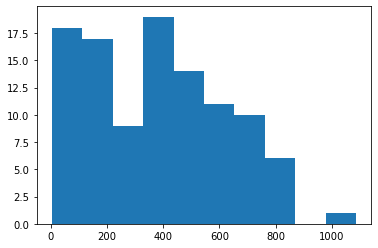

In [51]:
# Histogram of holding days

import matplotlib.pyplot as plt

days = []
for row in df.itertuples():
    days.append(row.time_delta.days)

plt.hist(days, bins=10)